In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, simps
from astropy.table import Table
from astropy.io import fits
import glob
import os
import string
import time

In [2]:
filelist = glob.glob("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
            "2016-06-20_all_filters_corrected_spectra/2016-06-20_*spec_*.fits")
filelist.sort()

In [ ]:
for specfile in filelist:
    plt.figure()
    plt.title(os.path.basename(specfile[-10:]))
    hdulist = fits.open(specfile)
    idxs = np.random.randint(1, 1000, size=7).tolist()
    for idx in idxs:
        hdu = hdulist[idx]
        spectra = hdu.data
        plt.plot(spectra.field('lambda'), spectra.field('flux'))
    plt.xlim(3000, 20500)

In [3]:
photometry = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
                        "2016-06-20_all_filters_corrected_spectra/2016-06-22_cosmossnap_photometry.out",
                        format="ascii")

IOError: [Errno 2] No such file or directory: '/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-06-20_all_filters_corrected_spectra/2016-06-22_cosmossnap_photometry.out'

In [ ]:
# Comparing to CS82 stuff
cs82 = Table.read("/share/splinter/moraes/2016-01-25_CS82_combined_products/cs82_morphology_exp.fit", format='fits')
mask = (cs82["IM_NUM"] == 120)
cs82tile = cs82[mask]
mauto = cs82tile["MAG_AUTO"]
merr = cs82tile["MAGERR_AUTO"]

In [ ]:
_ = plt.hist(photometry["Mapp_des_i"], bins=np.arange(18, 30, 0.2), facecolor='blue', alpha=0.2)
_ = plt.hist(photometry["Mapp_lsst_i"], bins=np.arange(18, 30, 0.2), facecolor='red', alpha=0.2)
_ = plt.hist(photometry["Mapp_panStarrs_i"], bins=np.arange(18, 30, 0.2), facecolor='green', alpha=0.2)
plt.figure()
_ = plt.hist(mauto, bins=np.arange(18, 30, 0.2))
plt.figure()
plt.plot(photometry["Mapp_des_i"], photometry["Err_des_i"], 'bo', alpha=0.2)
plt.plot(photometry["Mapp_lsst_i"], photometry["Err_lsst_i"], 'ro', alpha=0.2)
plt.plot(photometry["Mapp_panStarrs_i"], photometry["Err_panStarrs_i"], 'go', alpha=0.2)
plt.xlim(18, 30)
plt.plot(mauto, merr, 'm.')
plt.yscale("log")

# Checking redshift distribution

In [ ]:
_ = plt.hist(photometry["z"], bins=np.arange(0, 6, 0.1))

In [ ]:
np.sum(photometry["z"] < 0.7)

In [ ]:
zsmall = photometry[photometry["z"] < 0.7]
specIDs = zsmall["SpcExt"]
len(np.random.choice(len(specIDs), size=len(specIDs)//10, replace=False))

# PROTOTYPING POSTPROCESSING OF SPECTRA

In [22]:
def get_digits(name):
    translator = string.maketrans('', '')
    digit_trans = translator.translate(translator, string.digits)
    digits = name.translate(translator, digit_trans)
    return digits


def blueshift(spectrum, z):
    spectrum[:, 0] /= (1 + z)
    return spectrum


def get_maxfluxHa(spectrum):
    Hamask = (spectrum[:, 0] > 6540) & (spectrum[:, 0] < 6580)
    fluxHa = spectrum[Hamask]
    maxfluxHa = np.sum(fluxHa[:, 1])
    return maxfluxHa


def resample_and_integrate(spectrum, Lmin, Lmax, dL, resamp_prec=100):
    assert Lmin >= spectrum[:, 0].min(), "Lmin must be >= than min spectral wavelength"
    assert Lmax <= spectrum[:, 0].max(), "Lmax must be <= than max spectral wavelength"
    
    spline = interp1d(spectrum[:, 0], spectrum[:, 1])
    
    x = np.arange(Lmin, Lmax, dL/resamp_prec)
    xdata = x.reshape(int((Lmax - Lmin)/dL), resamp_prec)
    integrated_spec = simps(spline(xdata), dx=dL/resamp_prec, axis=1)
    
    out_spectrum = np.array([np.arange(Lmin + dL/2, Lmax + dL/2, dL), integrated_spec]).T
    assert out_spectrum.shape == ((Lmax - Lmin)/dL, 2)
    del spectrum
    
    return out_spectrum


###########
def main(folder, zmax, zfraction, Lmin, Lmax, dL, resamp_prec=100,
         outpath="./templates.csv", noise=[], flux_thresh=None):
    
    assert isinstance(noise, (list, tuple)), "noise must be a list or a tuple of ints or floats"

    # Create photometric filename list
    fnames_spec = glob.glob(os.path.join(folder, "*spec_*.fits"))
    fnames_phot = glob.glob(os.path.join(folder, "*.out"))
    fnames_spec.sort()
    fnames_phot.sort()
    assert len(fnames_spec) == len(fnames_phot), "Spectroscopic and photometric files don't match"
    
    # Create astropy table and resampled wavelength column
    wavelengths = np.arange(Lmin + dL/2, Lmax + dL/2, dL)
    
    # Initialize output tables
    colnames = []
    colnames.append("lambda")

    template_clean = []
    template_clean.append(wavelengths)
    
    templates_noise = []
    for n in range(len(noise)):
        template = []
        template.append(wavelengths)
        
        templates_noise.append(template)
    
    for i, (specname, photname) in enumerate(zip(fnames_spec, fnames_phot)):
        t0 = time.time()
        # Assert files are from the same run
        assert get_digits(specname) == get_digits(photname), "Ordering didn't work, files are not the same"

        # From photometry output, choose a subset of {zfraction}% spectra ID at redshift < {zmax}
        # and Halpha flux >= {flux_thresh}
        phot = Table.read(photname, format="ascii")
        lowz = phot[phot["z"] < zmax]
        if flux_thresh is not None:
            assert isinstance(flux_thresh, (float, int)), "flux_thresh must be an int or float"
            lowz = lowz[lowz["Flux_Ha"] >= flux_thresh]
        if len(lowz) == 0:
            continue
            
        np.random.seed(i)
        frac_lowz = np.random.choice(lowz, size=int(len(lowz)*zfraction), replace=False)
        print(len(frac_lowz))
        entries = frac_lowz["SpcExt"]
        specIDs = frac_lowz["Id"]
        redshifts = frac_lowz["z"]
        
        hdulist = fits.open(specname)
        for specID, entry, z in zip(specIDs, entries, redshifts):
            hdu = hdulist[entry]
            assert int(hdu.name) == specID, ("Spec ID from phot and spec cats " +
                                             "doesnt'match: %d vs %d" % (int(hdu.name), specID))
            hdudata = hdu.data
            spectrum = np.array([hdudata.field("lambda"), hdudata.field("flux")]).T
            spectrum = blueshift(spectrum, z)            
            spectrum = resample_and_integrate(spectrum, Lmin, Lmax, dL,
                                              resamp_prec=resamp_prec)
            colnames.append(str(specID))
            template_clean.append(spectrum[:, 1])
            
            for sigma, template_noise in zip(noise, templates_noise):
                spectrum_noise = spectrum[:, 1] + np.random.normal(0, sigma, size=len(spectrum[:, 1]))
                template_noise.append(spectrum_noise)
        t1 = time.time() - t0        
        print("File %d done in %.1f seconds!" % (i, t1))
    # Save table to outfolder
    outclean = os.path.join(os.path.dirname(outpath), "clean_" + os.path.basename(outpath))
    np.savetxt(outclean, np.array(template_clean).T, delimiter=",", header=",".join(colnames), comments="")
    
    for i, template_noise in enumerate(templates_noise):
        outnoise = os.path.join(os.path.dirname(outpath), "noise" + str(i) + "_" + os.path.basename(outpath))
        np.savetxt(outnoise, np.array(template_noise).T, delimiter=",", header=",".join(colnames), comments="")
    
    return None

In [23]:
main(folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",
     zmax=1.0, zfraction=0.5, Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,
     outpath="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/templates.csv",
     noise=[9.1187e-18, 8.5714e-17, 3e-16],
     flux_thresh=1e-16)

213
File 0 done in 24.2 seconds!
207
File 1 done in 24.1 seconds!
207
File 2 done in 24.3 seconds!
213
File 3 done in 24.1 seconds!
195
File 4 done in 24.2 seconds!
232
File 5 done in 24.7 seconds!
245
File 6 done in 24.5 seconds!
300
File 7 done in 25.7 seconds!
230
File 8 done in 26.7 seconds!
238
File 9 done in 25.4 seconds!
239
File 10 done in 24.8 seconds!
199
File 11 done in 29.0 seconds!
222
File 12 done in 29.3 seconds!
175
File 13 done in 28.9 seconds!
232
File 14 done in 33.6 seconds!
230
File 15 done in 28.6 seconds!
242
File 16 done in 26.3 seconds!
247
File 17 done in 26.6 seconds!
211
File 18 done in 26.4 seconds!
282
File 19 done in 31.5 seconds!
263
File 20 done in 28.5 seconds!
222
File 21 done in 30.6 seconds!
279
File 22 done in 31.4 seconds!
231
File 23 done in 30.5 seconds!
213
File 24 done in 30.3 seconds!
253
File 25 done in 30.8 seconds!
293
File 26 done in 29.1 seconds!
269
File 27 done in 26.8 seconds!
251
File 28 done in 27.3 seconds!
262
File 29 done in 27.2

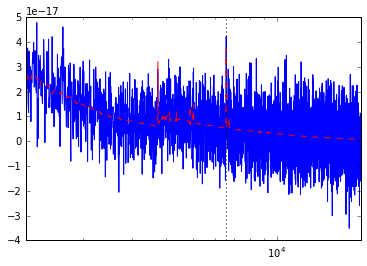

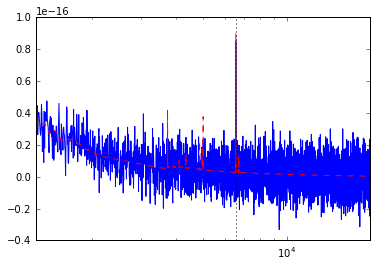

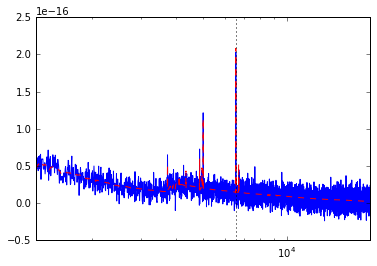

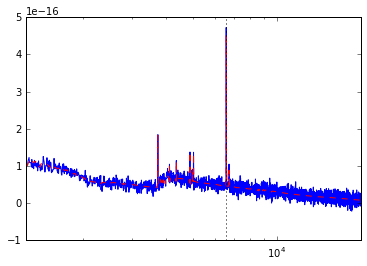

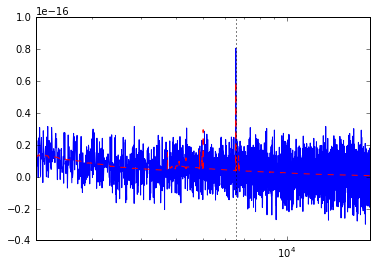

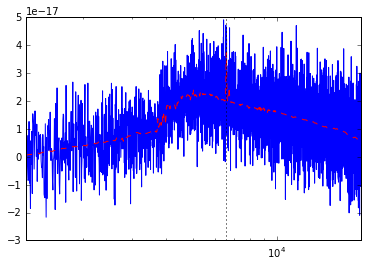

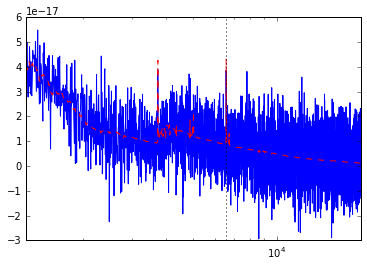

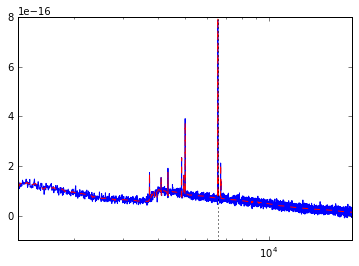

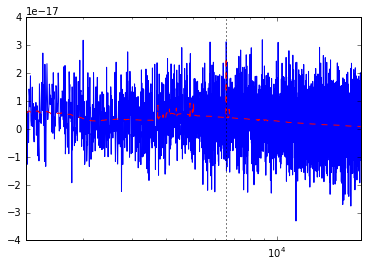

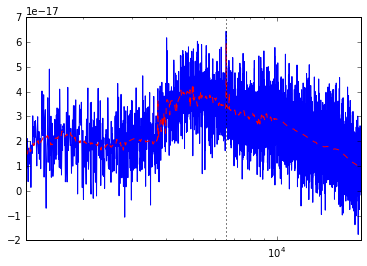

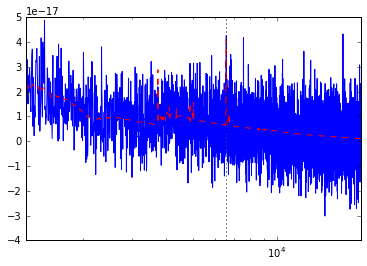

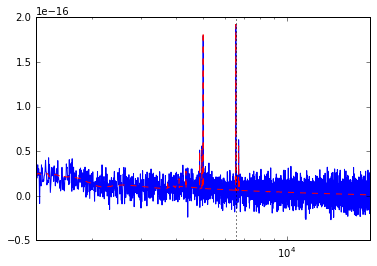

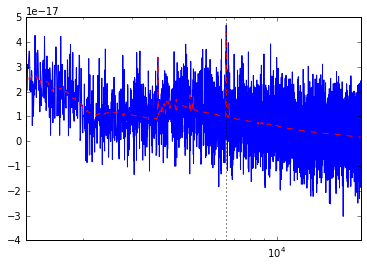

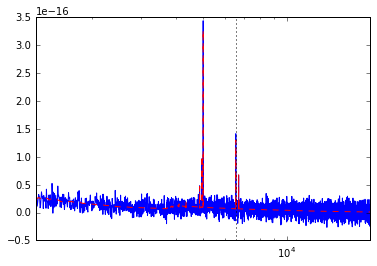

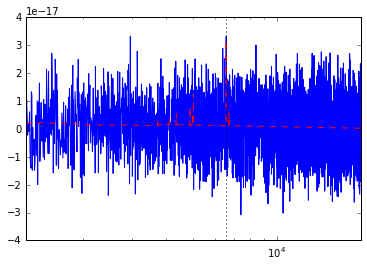

In [30]:
#test_spec = np.loadtxt("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
#                       "2016-09-06_euclid_run/clean_templates.csv", delimiter=",", skiprows=1)

#test_nonoise = np.loadtxt("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
#                       "2016-09-06_euclid_run/noise0_templates.csv", delimiter=",", skiprows=1)

for col in np.arange(1, len(test_spec[0]), 200):
    if col > 3000:
        break
    plt.figure()
    plt.plot(test_nonoise[:, 0], test_nonoise[:, col], "b")
    plt.plot(test_spec[:, 0], test_spec[:, col], "r--")
    plt.axvline(6563, color="k", linestyle=":")
    plt.xscale("log")
    #plt.yscale("log")
    plt.xlim(1.25e3, 2e4)

In [323]:
ls /share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/*csv

ls: /share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/*csv: No such file or directory


In [31]:
!head -n 1 /share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/clean_templates.csv | tr -cd , | wc -c

13708


In [7]:
load_ext line_profiler

In [21]:
lprun -f main main(folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",zmax=1.0, zfraction=0.5, Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,outpath="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/templates.csv", noise=[9.1187e-18, 8.5714e-17, 3e-16],flux_thresh=1e-16)

213
File 0 done!


# Checking spectra amplitude normalization

In [83]:
specname = "/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_spec_16.fits"

In [84]:
hdulist=fits.open(specname)

In [85]:
spectrum = hdulist["733850"].data

In [70]:
np.random.normal(scale=(3/3.5)*1e-16, size=len(spectrum))

array([  8.27456446e-17,   1.32743387e-16,  -7.48587217e-17, ...,
        -1.49103235e-17,  -1.07264877e-17,  -7.82310439e-17])

In [43]:
def mab(fL, Lc, dL):
    term1 = -2.5*np.log10(fL*dL)
    term2 = 2.5*np.log10(0.1088*(dL/(Lc*Lc - dL*dL/4)))
    return term1 + term2

In [58]:
mab(1.9e-17, 6250, 1500)

20.43103641225208

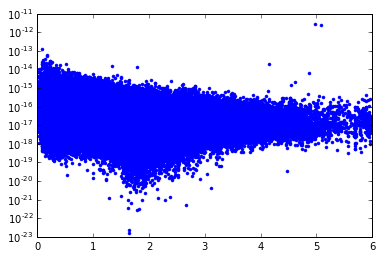

In [94]:
plt.plot(photometry["z"], photometry["Flux_Ha"], "b.", linestyle="")
plt.yscale("log")

In [151]:
spec16 = fits.open("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_spec_16.fits")
phot16 = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_16.out", format="ascii")

In [152]:
phot16[:10]["Id", "Flux_Ha", "Conti_Ha"]

Id,Flux_Ha,Conti_Ha
int64,float64,float64
733850,2.43625e-18,5.95806e-30
733854,1.7071e-17,2.12057e-30
733855,0.0,1.80493e-28
733856,9.61243e-17,7.36368e-30
733858,1.71131e-17,6.51217e-30
733859,9.03822e-18,1.90608e-30
733860,1.71908e-18,2.37982e-30
733861,1.591e-18,2.21135e-29
733871,2.87181e-17,4.93376e-30


In [169]:
spectra = [spec16[int(idspec)].data for idspec in phot16[:10]["SpcExt"].data]

In [173]:
phot16["Id", "SpcExt"]

Id,SpcExt
int64,int64
733850,1079
733854,7769
733855,213
733856,9079
733858,6725
733859,9256
733860,1643
733861,512
733871,4983


In [277]:
int(spec16[11].name)

738042

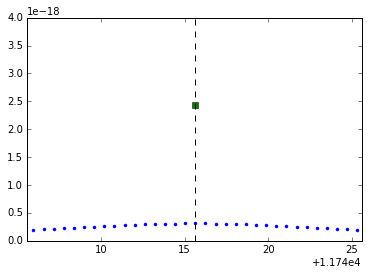

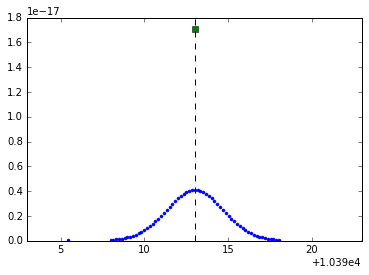

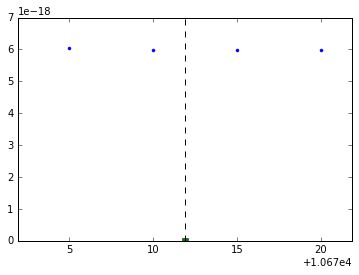

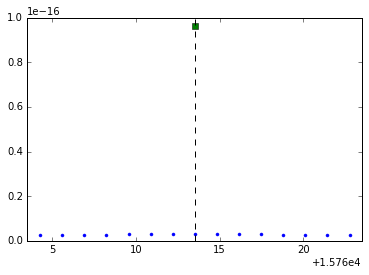

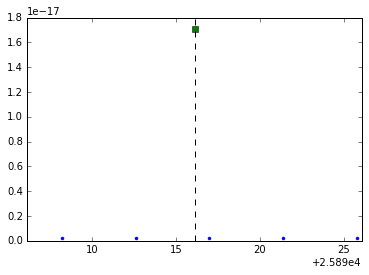

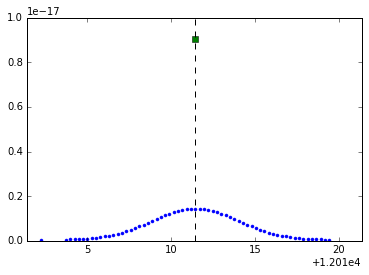

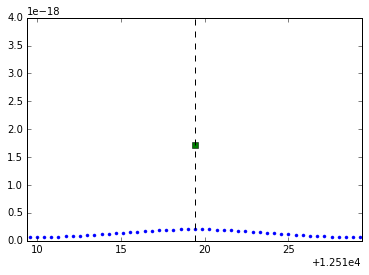

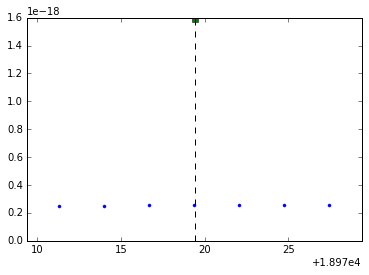

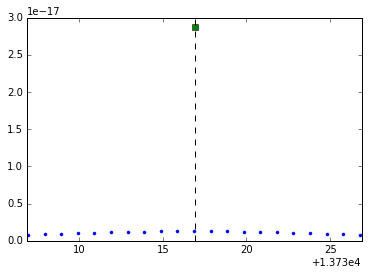

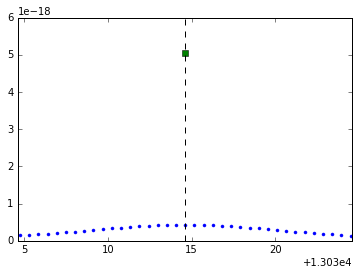

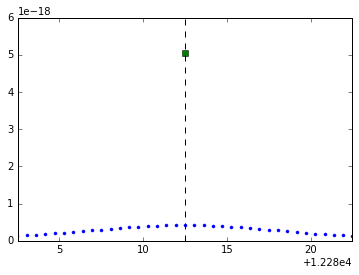

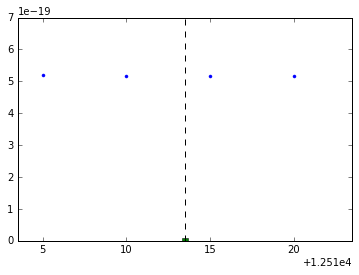

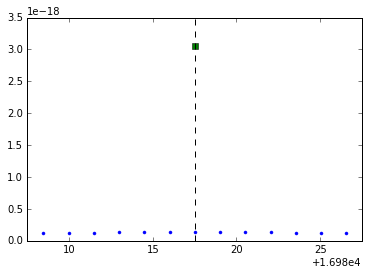

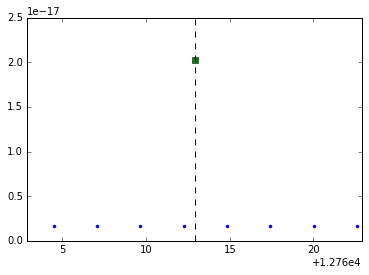

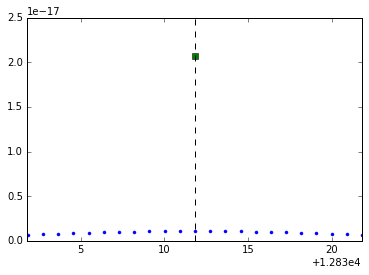

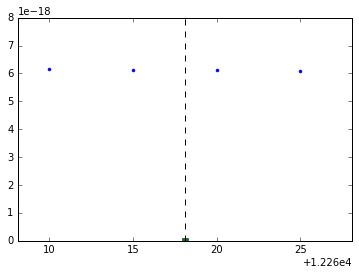

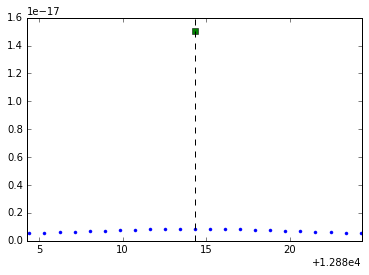

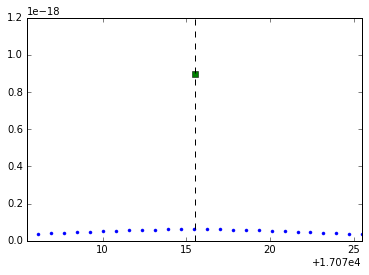

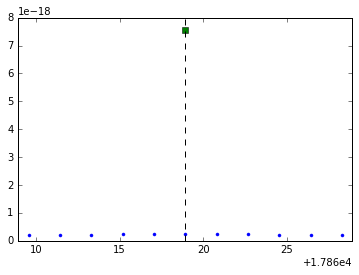

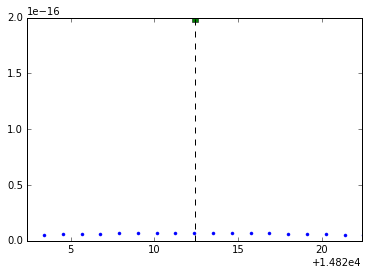

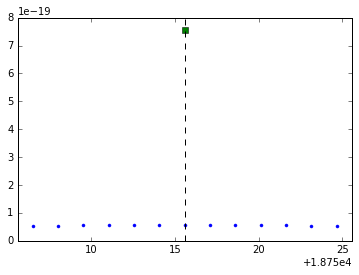

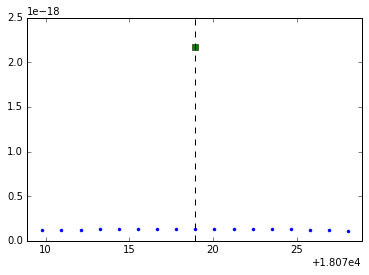

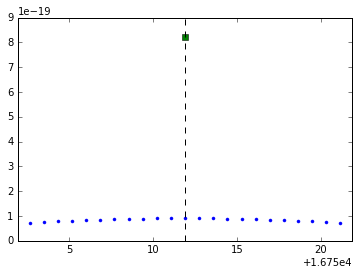

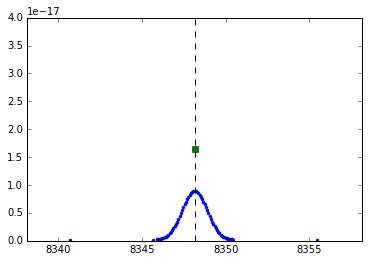

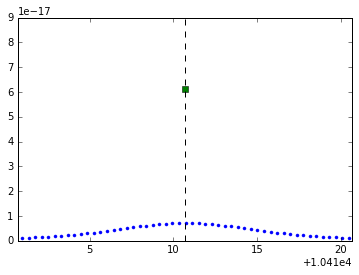

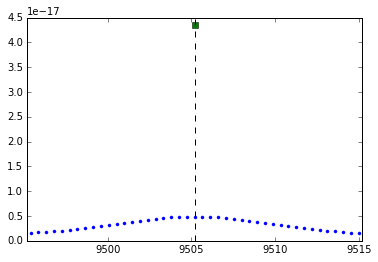

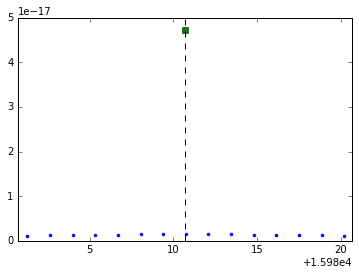

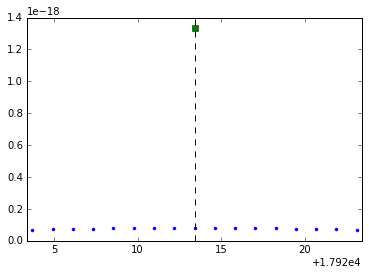

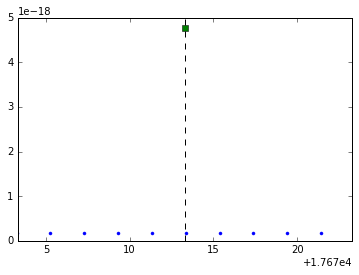

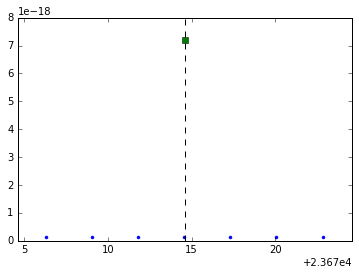

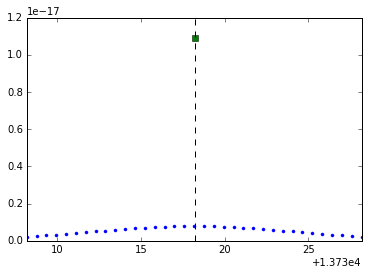

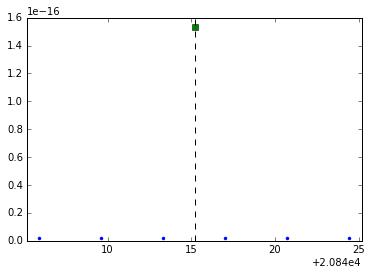

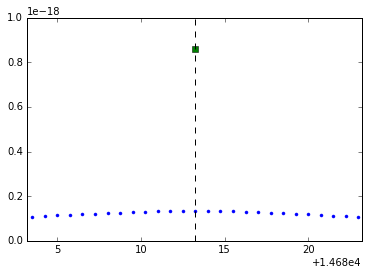

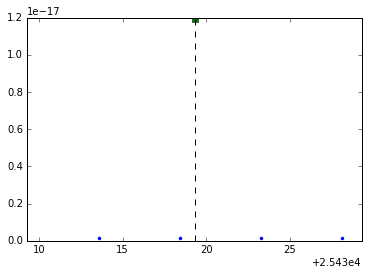

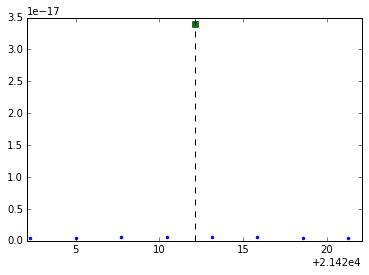

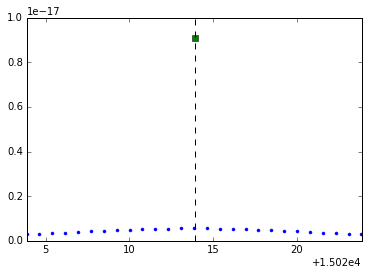

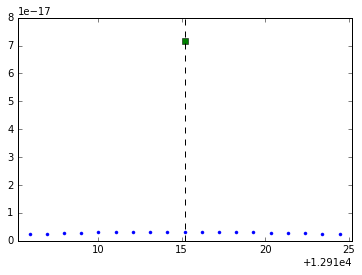

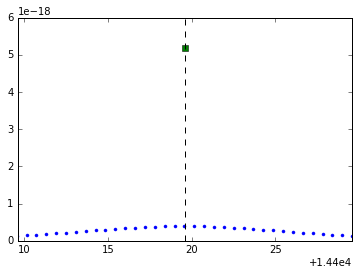

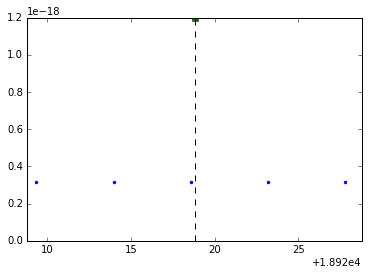

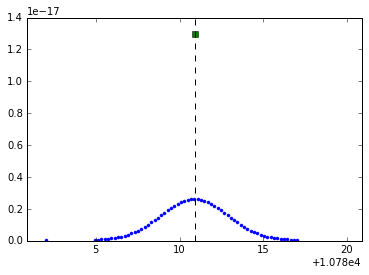

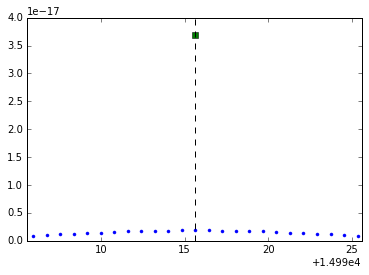

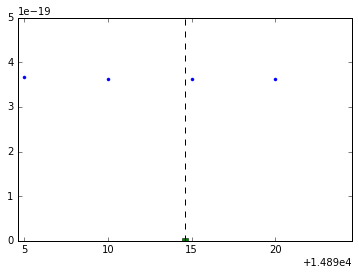

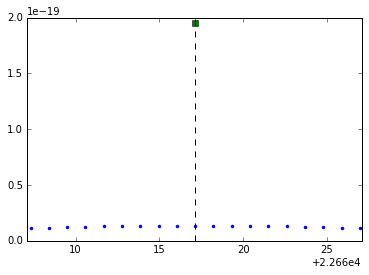

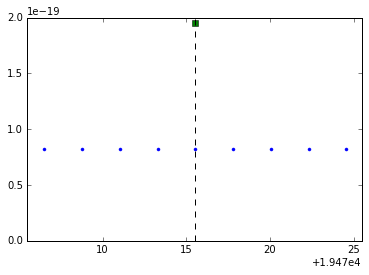

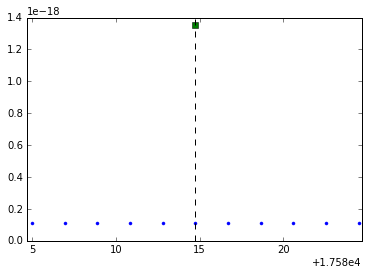

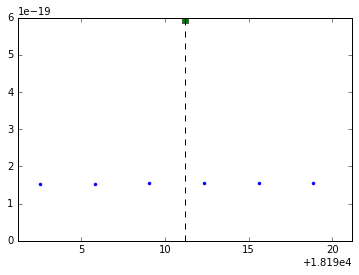

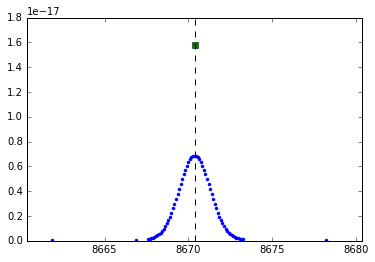

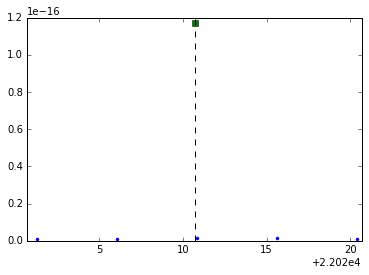

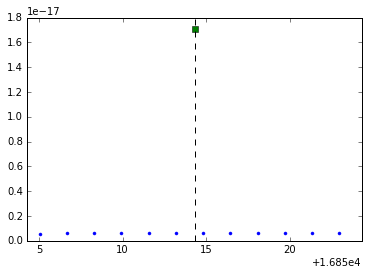

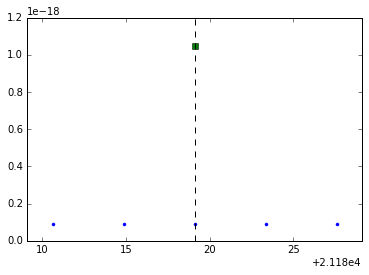

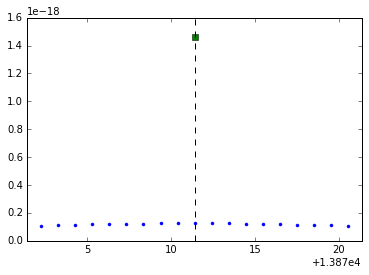

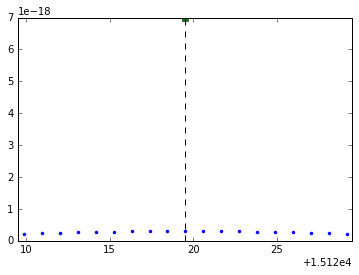

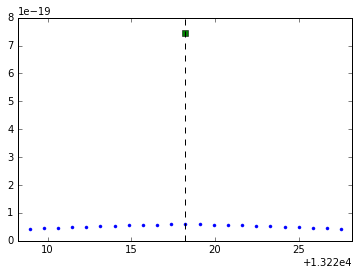

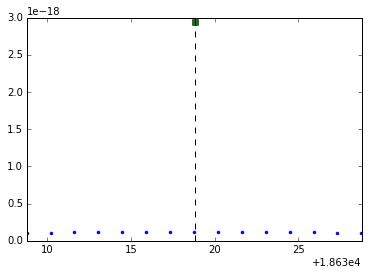

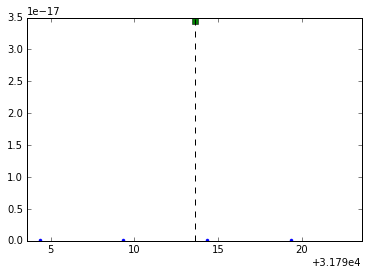

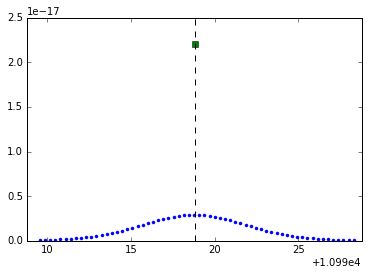

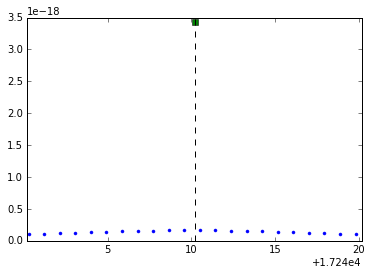

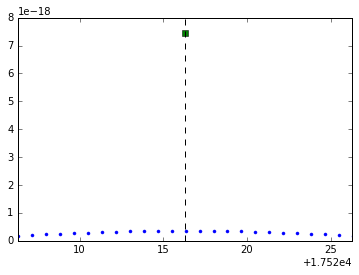

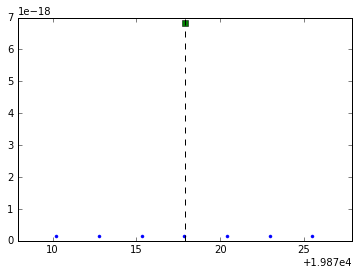

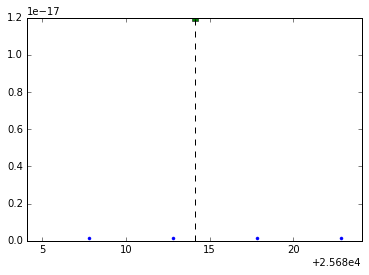

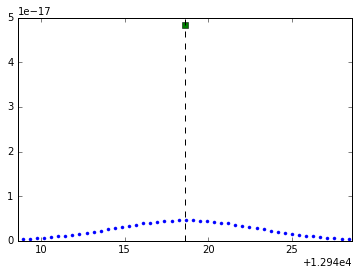

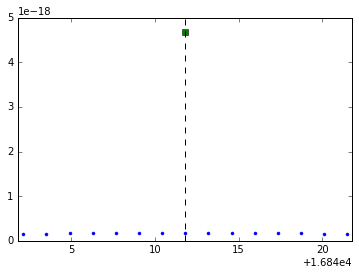

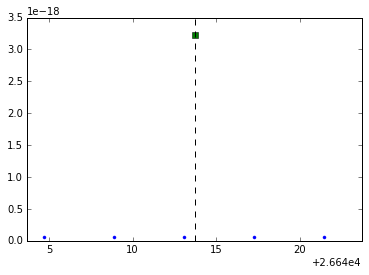

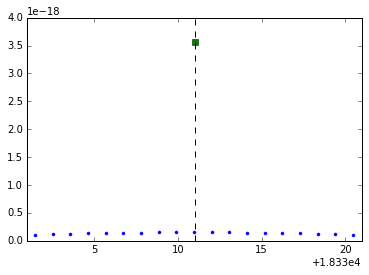

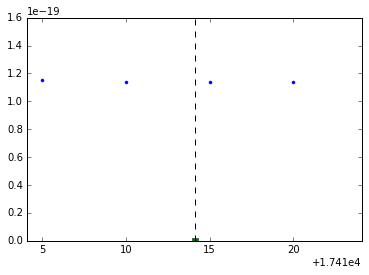

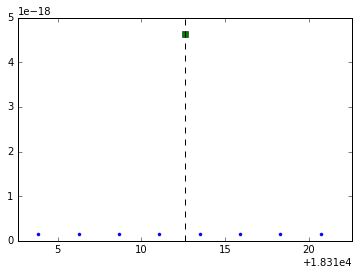

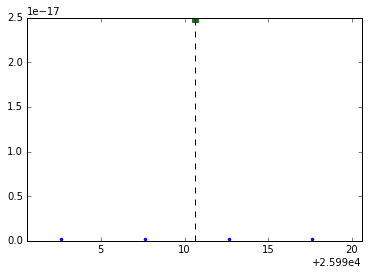

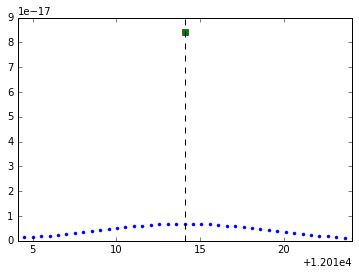

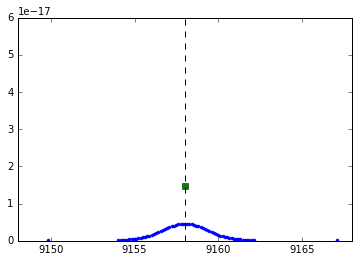

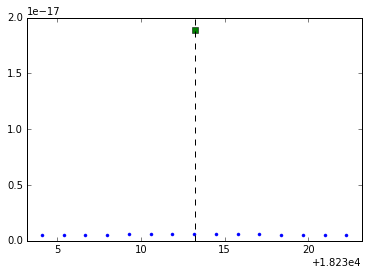

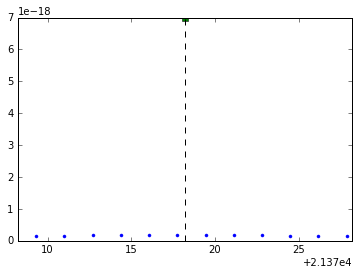

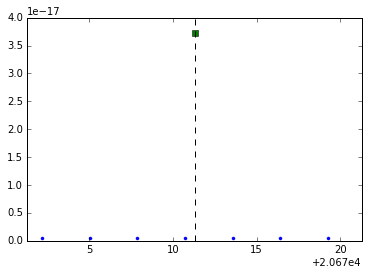

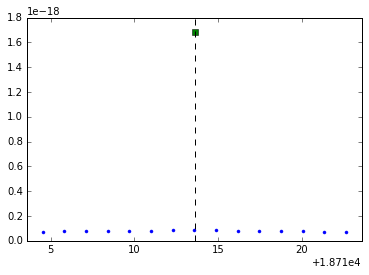

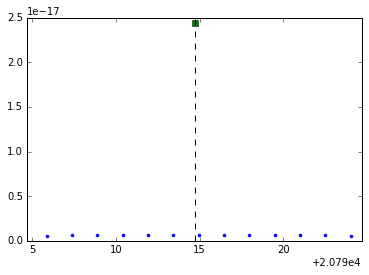

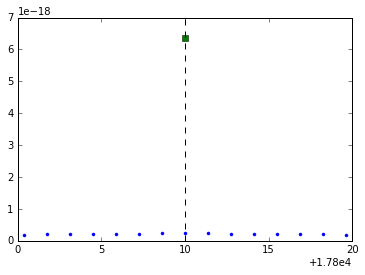

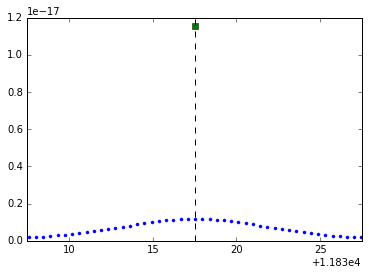

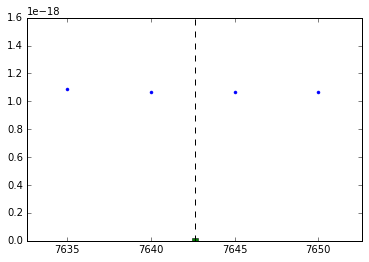

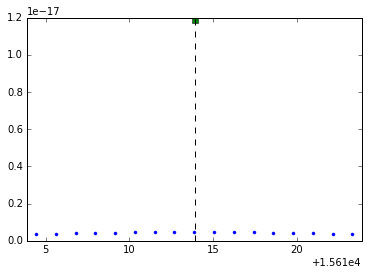

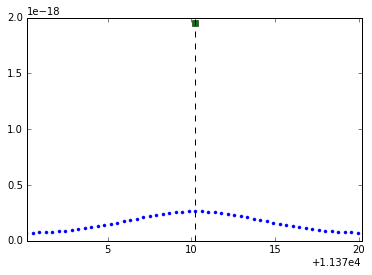

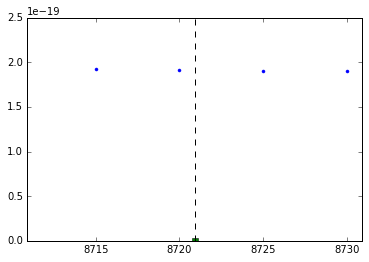

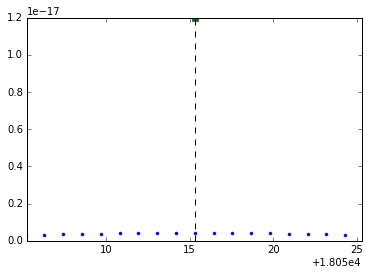

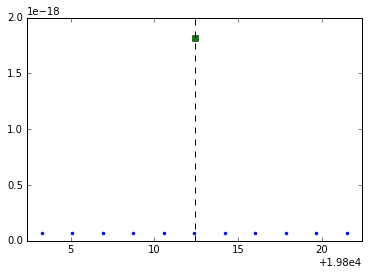

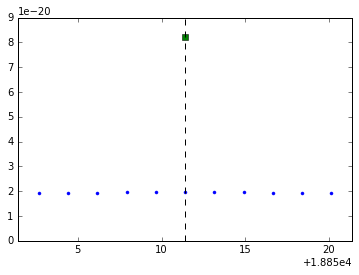

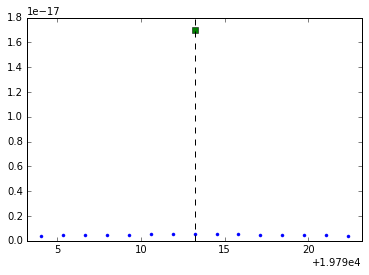

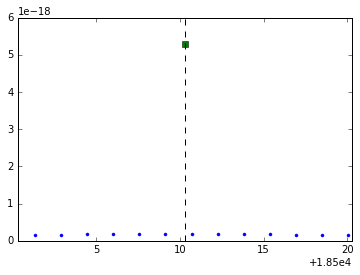

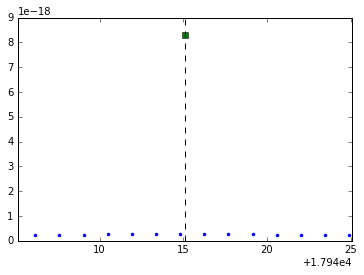

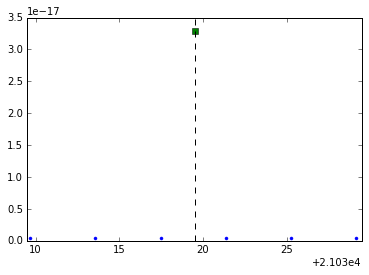

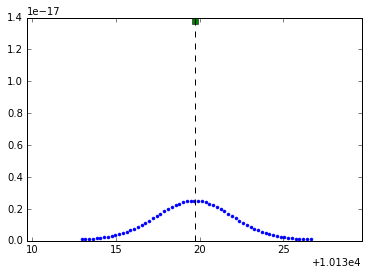

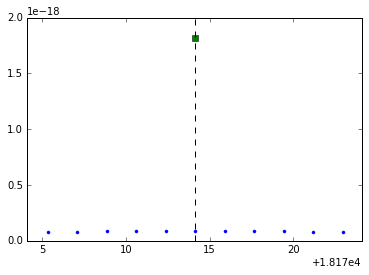

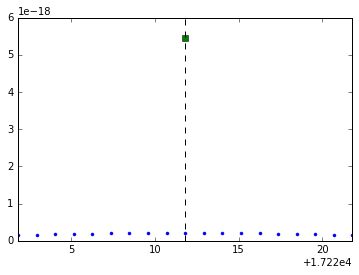

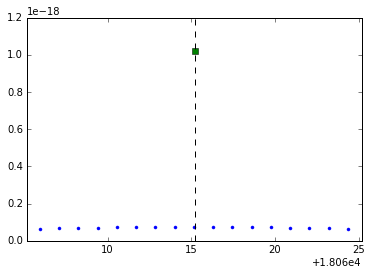

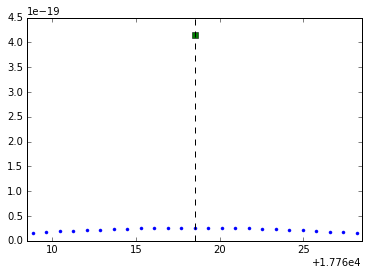

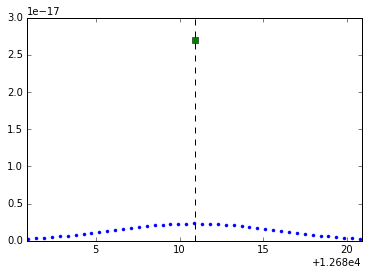

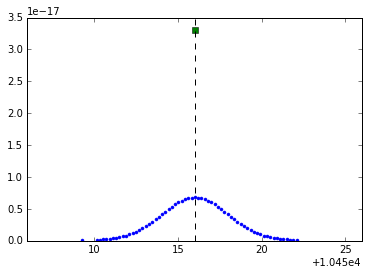

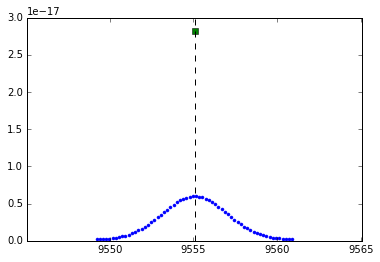

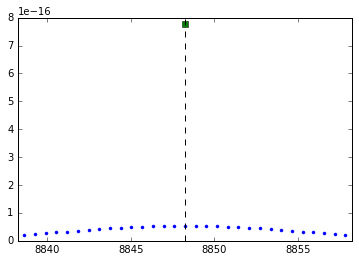

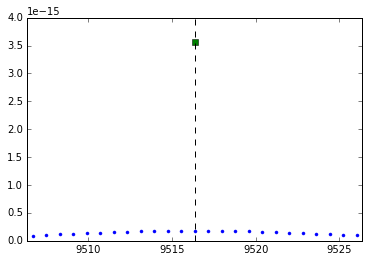

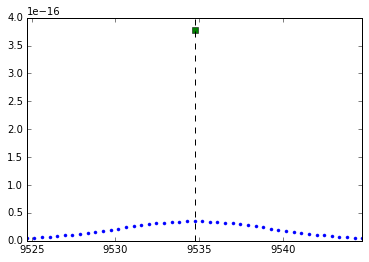

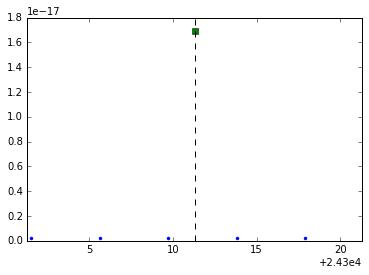

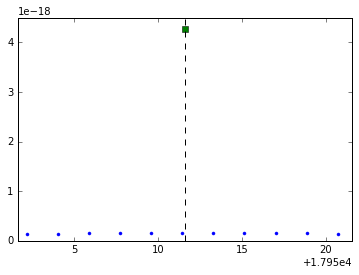

In [170]:
for lambdaHa, fluxHa, spectrum in zip(phot16[:10]["Lambda_Ha"], phot16[:10]["Flux_Ha"], spectra):
    plt.figure()
    plt.plot(spectrum.field("lambda"), spectrum.field("flux"), ".")
    plt.plot(lambdaHa, fluxHa, "s")
    plt.axvline(lambdaHa, linestyle="--", color="k")
    plt.xlim(lambdaHa-10, lambdaHa+10)

In [37]:
test_spec = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
                       "2016-09-06_euclid_run/templates_clean.csv", format="ascii.basic", delimiter=",")

In [42]:
len(test_spec.colnames)

13709